In [45]:
import tensorflow as tf
import keras
from keras.layers import Dense, Conv2D, Conv2DTranspose, Flatten, Input, Lambda, Reshape
from keras.models import Model
from keras.datasets import mnist
from keras import backend as K
from keras import metrics
import numpy as np
import matplotlib.pyplot as plt

In [46]:
# Load MNIST dataset
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# Reshape and normalize data
image_size = x_train.shape[1]
x_train = np.reshape(x_train, [-1, image_size, image_size, 1])
x_test = np.reshape(x_test, [-1, image_size, image_size, 1])
x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255


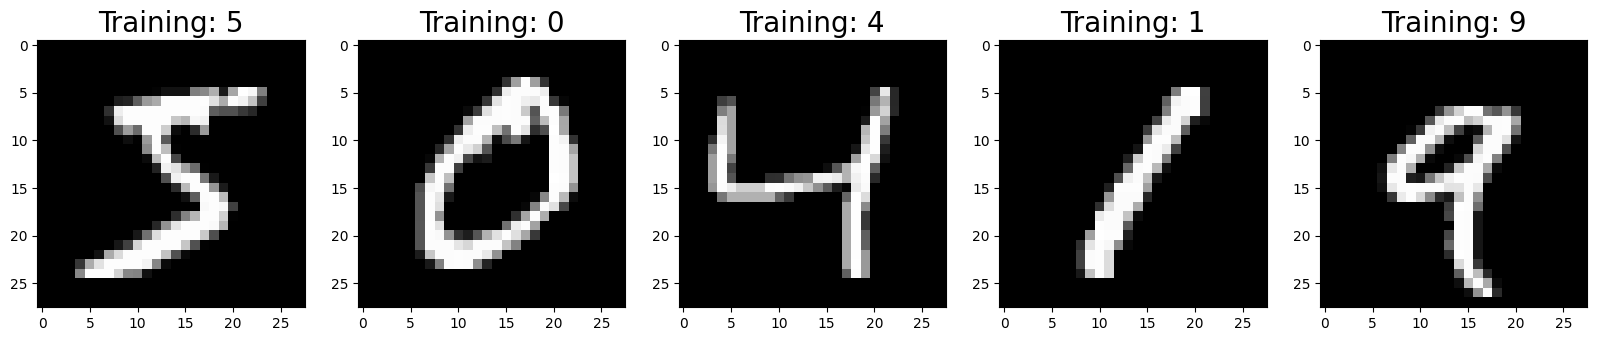

In [47]:
# Plot some of the images
plt.figure(figsize=(20, 4))
for index, (image, label) in enumerate(zip(x_train[0:5], y_train[0:5])):
    plt.subplot(1, 5, index + 1)
    plt.imshow(np.reshape(image, [image_size, image_size]), cmap=plt.cm.gray)
    plt.title('Training: %i' % label, fontsize = 20)


In [48]:
# Build the encoder
latent_dim = 2
input_shape = (image_size, image_size, 1)

inputs = Input(shape=input_shape, name='encoder_input')

# Convolutional layers
x = Conv2D(filters=32, kernel_size=3, activation='relu', strides=2, padding='same')(inputs)
x = Conv2D(filters=64, kernel_size=3, activation='relu', strides=(2,2), padding='same')(x)
x = Conv2D(filters=64, kernel_size=3, activation='relu', padding='same')(x)
x = Conv2D(filters=64, kernel_size=3, activation='relu', padding='same')(x)

encoder_shape = K.int_shape(x)

# Flatten and add fully connected layer
x = Flatten()(x)
x = Dense(32, activation='relu')(x)

# Latent space
z_mean = Dense(latent_dim, name='z_mean')(x)
z_log_var = Dense(latent_dim, name='z_log_var')(x)

In [49]:
# Sampling function using reparameterization trick
class Sampling(keras.layers.Layer):
    
    def call(self, args):
        z_mean, z_log_var = args
        epsilon = K.random_normal(shape=(K.shape(z_mean)[0], latent_dim), mean=0., stddev=1.) # N(0,1)
        return z_mean + K.exp(z_log_var / 2) * epsilon

In [50]:
# Use reparameterization trick to push the sampling out as input
z = Sampling()([z_mean, z_log_var])

In [51]:
# Instantiate encoder model
encoder = Model(inputs, [z_mean, z_log_var, z], name='encoder')
encoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 encoder_input (InputLayer)     [(None, 28, 28, 1)]  0           []                               
                                                                                                  
 conv2d_16 (Conv2D)             (None, 14, 14, 32)   320         ['encoder_input[0][0]']          
                                                                                                  
 conv2d_17 (Conv2D)             (None, 7, 7, 64)     18496       ['conv2d_16[0][0]']              
                                                                                                  
 conv2d_18 (Conv2D)             (None, 7, 7, 64)     36928       ['conv2d_17[0][0]']              
                                                                                            

In [52]:
# Build the decoder
latent_inputs = Input(shape=(latent_dim,), name='z_sampling')
x = Dense(encoder_shape[1] * encoder_shape[2] * encoder_shape[3], activation='relu')(latent_inputs)
x = Reshape((encoder_shape[1], encoder_shape[2], encoder_shape[3]))(x)

# Convolutional layers
x = Conv2DTranspose(64, 3, activation="relu", strides=2, padding="same")(x)
x = Conv2DTranspose(32, 3, activation="relu", strides=2, padding="same")(x)
x = Conv2DTranspose(1, 3, activation="sigmoid", padding="same")(x)
# Instantiate decoder model
decoder = Model(latent_inputs, x, name='decoder')
decoder.summary()

z_decoded = decoder(z)

Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 z_sampling (InputLayer)     [(None, 2)]               0         
                                                                 
 dense_9 (Dense)             (None, 3136)              9408      
                                                                 
 reshape_4 (Reshape)         (None, 7, 7, 64)          0         
                                                                 
 conv2d_transpose_9 (Conv2DT  (None, 14, 14, 64)       36928     
 ranspose)                                                       
                                                                 
 conv2d_transpose_10 (Conv2D  (None, 28, 28, 32)       18464     
 Transpose)                                                      
                                                                 
 conv2d_transpose_11 (Conv2D  (None, 28, 28, 1)        289 

In [53]:
class VAE(keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super().__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = keras.metrics.Mean(
            name="reconstruction_loss"
        )
        self.kl_loss_tracker = keras.metrics.Mean(name="kl_loss")

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
        ]

    def train_step(self, data):
        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = self.encoder(data)
            reconstruction = self.decoder(z)
            reconstruction_loss = tf.reduce_mean(
                tf.reduce_sum(
                    keras.losses.binary_crossentropy(data, reconstruction), axis=(1, 2)
                )
            )
            kl_loss = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
            kl_loss = tf.reduce_mean(tf.reduce_sum(kl_loss, axis=1))
            total_loss = reconstruction_loss + kl_loss

        trainable_vars = self.trainable_variables
        trainable_weights = self.trainable_weights

        gradients = tape.gradient(total_loss, trainable_vars)
        self.optimizer.apply_gradients(zip(gradients, trainable_weights))

        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)

        return {
            "Total Loss": self.total_loss_tracker.result(),
            "Reconstruction Loss": self.reconstruction_loss_tracker.result(),
            "KL-Loss": self.kl_loss_tracker.result(),
        }

In [54]:
vae = VAE(encoder, decoder)
vae.compile(optimizer='adam', loss=None)

In [55]:
# Train the autoencoder
vae.fit(x_train, None, epochs=10, batch_size=128, validation_split=0.2)

Epoch 1/10


2023-01-07 14:08:57.015421: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


374/375 [============================>.] - ETA: 0s - Total Loss: 262.8928 - Reconstruction Loss: 257.9432 - KL-Loss: 4.9496

NotImplementedError: in user code:

    File "/opt/homebrew/Caskroom/miniforge/base/envs/Project/lib/python3.10/site-packages/keras/engine/training.py", line 1727, in test_function  *
        return step_function(self, iterator)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/Project/lib/python3.10/site-packages/keras/engine/training.py", line 1713, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/opt/homebrew/Caskroom/miniforge/base/envs/Project/lib/python3.10/site-packages/keras/engine/training.py", line 1701, in run_step  **
        outputs = model.test_step(data)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/Project/lib/python3.10/site-packages/keras/engine/training.py", line 1665, in test_step
        y_pred = self(x, training=False)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/Project/lib/python3.10/site-packages/keras/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/opt/homebrew/Caskroom/miniforge/base/envs/Project/lib/python3.10/site-packages/keras/engine/training.py", line 584, in call
        raise NotImplementedError(

    NotImplementedError: Exception encountered when calling layer "vae_4" "                 f"(type VAE).
    
    Unimplemented `tf.keras.Model.call()`: if you intend to create a `Model` with the Functional API, please provide `inputs` and `outputs` arguments. Otherwise, subclass `Model` with an overridden `call()` method.
    
    Call arguments received by layer "vae_4" "                 f"(type VAE):
      • inputs=tf.Tensor(shape=(None, 28, 28, 1), dtype=float32)
      • training=False
      • mask=None
